# Analysis of Review Time vs Retention and Rating

This notebook explores how real review durations (ms) correlate with FSRS-estimated retrievability and the ratings provided by the user.

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Add src to path
sys.path.append(os.path.abspath("../src"))

from simulate_fsrs import RustOptimizer, get_review_history_stats, load_anki_history

# Configuration
SEED_HISTORY = "../collection.anki2"
DECK_CONFIG = "ChineseReading"

if not os.path.exists(SEED_HISTORY):
    raise FileNotFoundError(f"{SEED_HISTORY} not found!")

## 1. Data Loading and FSRS Fitting
We load the history for the specified deck config and fit FSRS-6 parameters to get accurate retrievability estimates.

In [2]:
print(f"Loading history for {DECK_CONFIG}...")
logs, _ = load_anki_history(SEED_HISTORY, deck_config_name=DECK_CONFIG)
flat_logs = [log for card_logs in logs.values() for log in card_logs]

print(f"Fitting FSRS-6 parameters on {len(flat_logs)} reviews...")
optimizer = RustOptimizer(flat_logs)
fitted_params = tuple(optimizer.compute_optimal_parameters())
print(f"Fitted params: {fitted_params}")

Loading history for ChineseReading...
Anki database version 18 detected.
Querying reviews for 1 matching decks...
Successfully loaded 149671 reviews for 13641 cards.
Review date range: 2019-02-09 to 2026-01-24
Fitting FSRS-6 parameters on 149671 reviews...
Fitted params: (0.0027563616167753935, 1.5865014791488647, 15.527191162109375, 15.527191162109375, 6.413300037384033, 0.8334000110626221, 3.019399881362915, 0.0010000000474974513, 1.8722000122070312, 0.16660000383853912, 0.7960000038146973, 1.4835000038146973, 0.061400000005960464, 0.2628999948501587, 1.648300051689148, 0.6014000177383423, 1.8729000091552734, 0.5425000190734863, 0.09120000153779984, 0.0658000037074089, 0.1542000025510788)


## 2. Replaying History
We replay the history using the fitted parameters to calculate the estimated retrievability at the moment of each review.

In [3]:
print("Replaying history...")
stats = get_review_history_stats(logs, fitted_params)
df = pd.DataFrame(stats)

# Filter out reviews with missing duration (0 or None)
df = df[df["duration"] > 0].copy()

# Convert duration from ms to seconds for easier reading
df["duration_sec"] = df["duration"] / 1000.0

# Clip extreme outliers for plotting (e.g. 99th percentile)
upper_limit = df["duration_sec"].quantile(0.99)
df_clean = df[df["duration_sec"] <= upper_limit].copy()

df_clean.head()

Replaying history...


,card_id,retention,rating,duration,stability,difficulty,elapsed_days,duration_sec
0,1393817670651,0.519463,4,4539.0,0.000000,3.259772,0.000000,4.539
1,1393817670651,0.973607,4,4309.0,15.527191,1.000000,3.916837,4.309
2,1393817670651,0.953790,4,5875.0,40.950215,1.000000,15.162529,5.875
3,1393817670651,0.958270,4,5133.0,141.624388,1.000000,46.437872,5.133
4,1393817670651,0.947371,3,2822.0,396.869293,1.000000,170.931361,2.822


## 3. Visualization: Retention vs Review Time
We bucket retrievability into 5% increments and use a box plot to show the distribution of study times.

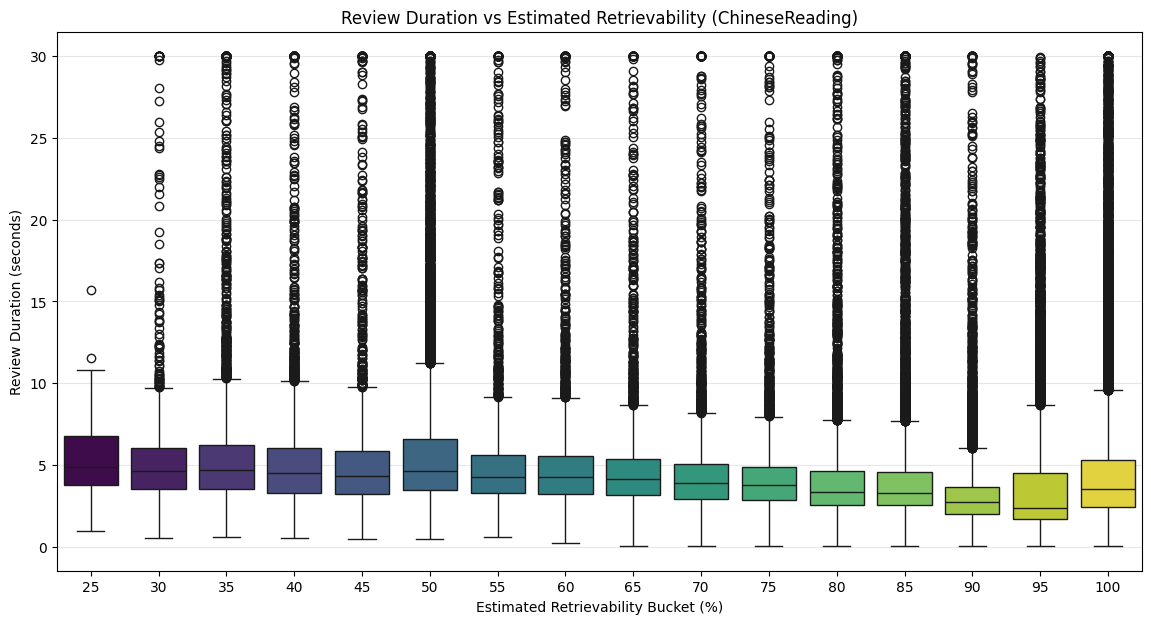

In [4]:
df_clean["retention_bucket"] = (df_clean["retention"] * 20).astype(int) * 5

plt.figure(figsize=(14, 7))
sns.boxplot(
    data=df_clean,
    x="retention_bucket",
    y="duration_sec",
    palette="viridis",
    hue="retention_bucket",
    legend=False,
)
plt.title("Review Duration vs Estimated Retrievability (ChineseReading)")
plt.xlabel("Estimated Retrievability Bucket (%)")
plt.ylabel("Review Duration (seconds)")
plt.grid(axis="y", alpha=0.3)
plt.show()

## 4. Visualization: Rating vs Review Time
Comparing durations for Again, Hard, Good, and Easy ratings.

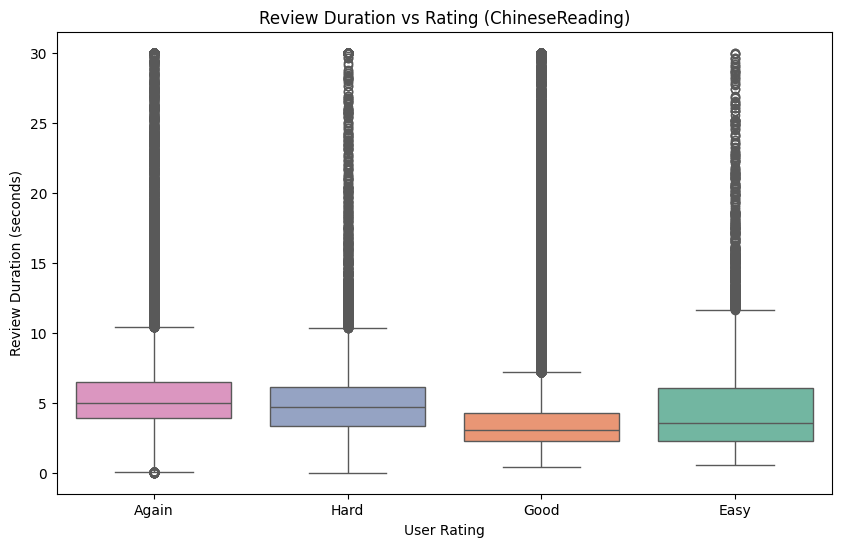

In [5]:
rating_map = {1: "Again", 2: "Hard", 3: "Good", 4: "Easy"}
df_clean["rating_label"] = df_clean["rating"].map(rating_map)

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_clean,
    x="rating_label",
    y="duration_sec",
    order=["Again", "Hard", "Good", "Easy"],
    palette="Set2",
    hue="rating_label",
    legend=False,
)
plt.title("Review Duration vs Rating (ChineseReading)")
plt.xlabel("User Rating")
plt.ylabel("Review Duration (seconds)")
plt.show()

## 5. Numerical Assessment: Correlation Matrix
Checking the linear relationship strength between variables.

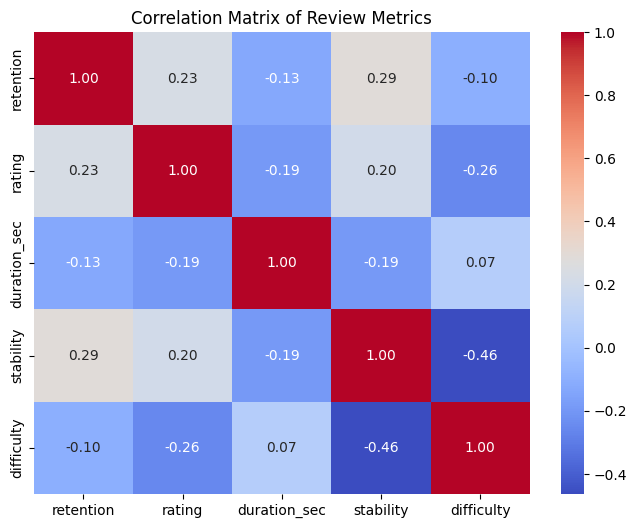

In [6]:
corr = df_clean[
    ["retention", "rating", "duration_sec", "stability", "difficulty"]
].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Review Metrics")
plt.show()

## 6. Predictive Modeling: Lasso Regression
We fit a Lasso model using cross-validation to predict duration_sec from retention and rating.

Optimal Alpha: 0.077189
R-squared: 0.0645
--- Coefficients ---
retention: -0.1709
rating: -0.6020
stability: -0.6224
difficulty: -0.0897


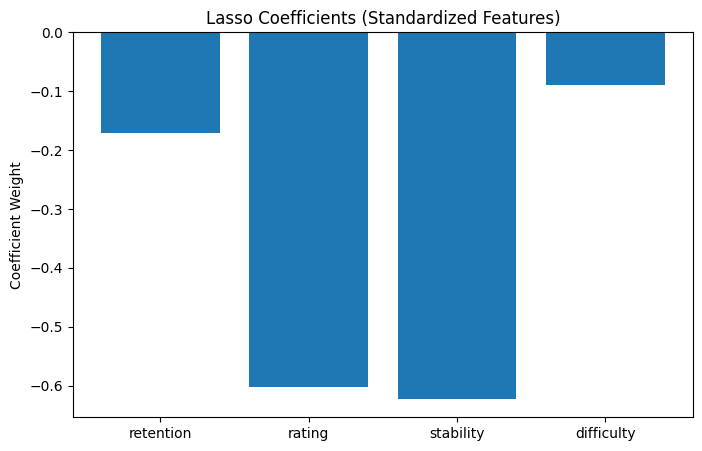

In [7]:
# Prepare features and target
features = ["retention", "rating", "stability", "difficulty"]
X = df_clean[features].values
y = df_clean["duration_sec"].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Lasso with Cross-Validation to select alpha
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

print(f"Optimal Alpha: {lasso.alpha_:.6f}")
print(f"R-squared: {lasso.score(X_scaled, y):.4f}")
print("--- Coefficients ---")
for feat, coef in zip(features, lasso.coef_, strict=False):
    print(f"{feat}: {coef:.4f}")

plt.figure(figsize=(8, 5))
plt.bar(features, lasso.coef_)
plt.title("Lasso Coefficients (Standardized Features)")
plt.ylabel("Coefficient Weight")
plt.show()

## 7. Optimal Retention Analysis: Constant Time
We run simulations with a range of target retentions (0.7 to 0.95) and a fixed daily time budget (e.g. 30 minutes). In this scenario, we assume every review takes exactly the mean duration found in the data.

Daily budget: 1800s, Mean duration: 4.72s
Simulating ret=0.7...
Simulating ret=0.75...
Simulating ret=0.8...
Simulating ret=0.85...
Simulating ret=0.9...
Simulating ret=0.93...
Simulating ret=0.95...


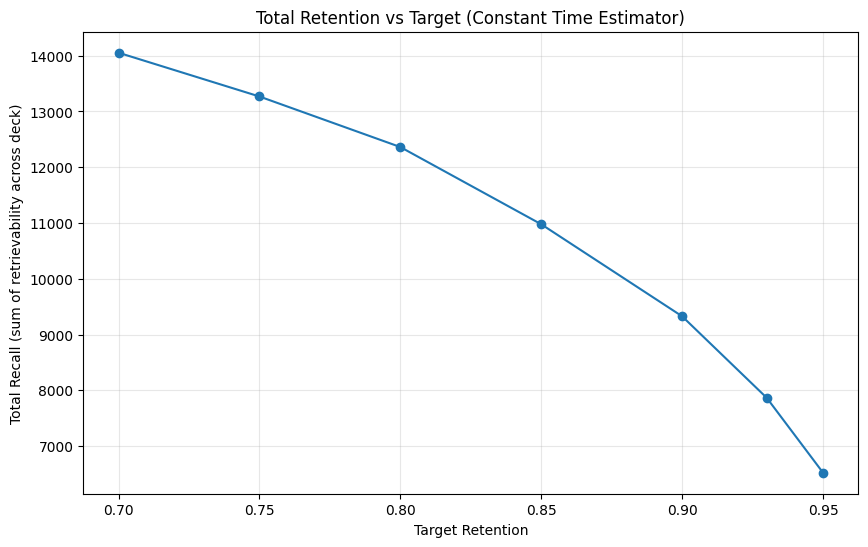

In [8]:
from simulate_fsrs import run_simulation

daily_budget_sec = 30 * 60  # 30 minutes
mean_duration_sec = df_clean["duration_sec"].mean()
print(f"Daily budget: {daily_budget_sec}s, Mean duration: {mean_duration_sec:.2f}s")

retentions = [0.7, 0.75, 0.8, 0.85, 0.9, 0.93, 0.95]
results_constant = []


# Updated signature to accept current_date
def constant_time_estimator(card, rating, current_date):
    return mean_duration_sec


for ret in retentions:
    print(f"Simulating ret={ret}...")
    _, _, metrics = run_simulation(
        n_days=180,
        retention=str(ret),
        time_limit=daily_budget_sec,
        time_estimator=constant_time_estimator,
        verbose=False,
    )
    results_constant.append(metrics["total_retention"])

plt.figure(figsize=(10, 6))
plt.plot(retentions, results_constant, marker="o")
plt.title("Total Retention vs Target (Constant Time Estimator)")
plt.xlabel("Target Retention")
plt.ylabel("Total Recall (sum of retrievability across deck)")
plt.grid(True, alpha=0.3)
plt.show()

## 8. Optimal Retention Analysis: Lasso Model Time
In this scenario, we use our fitted Lasso model to estimate the time for each review based on the simulated retention and rating.

Simulating ret=0.7...
Simulating ret=0.75...
Simulating ret=0.8...
Simulating ret=0.85...
Simulating ret=0.9...
Simulating ret=0.93...
Simulating ret=0.95...


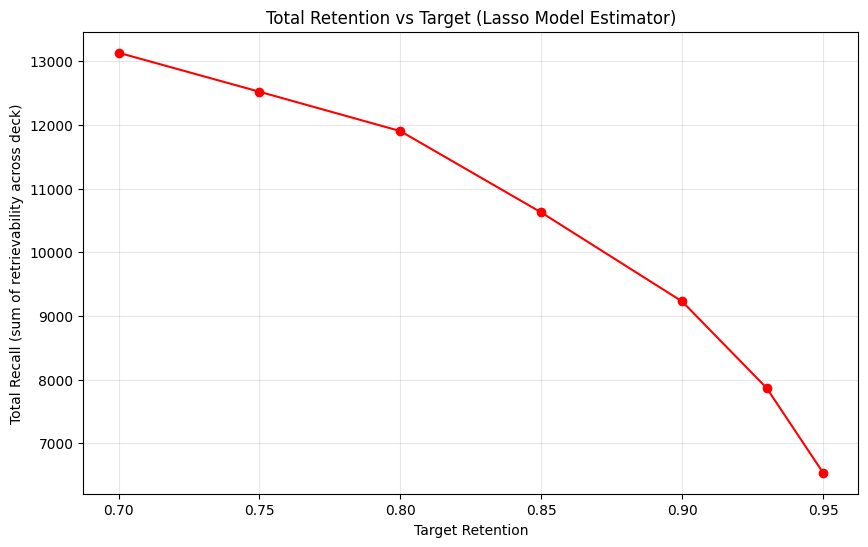

In [9]:
# We need a scheduler to calculate retrievability inside the estimator

import numpy as np

from simulate_fsrs import Scheduler, calculate_expected_d0, infer_review_weights

# Calculate baseline features for new cards (consistent with get_review_history_stats)
weights_h = infer_review_weights(logs)
w_first = weights_h["first"]
prob_first_success = 1.0 - w_first[0]
expected_d0 = calculate_expected_d0(w_first, fitted_params)

# Lasso estimator wrapper
sch = Scheduler(parameters=fitted_params)


def lasso_time_estimator(card, rating, current_date):
    # Use Card attributes, handling None for new cards
    s = card.stability

    if s is None or s == 0:
        # Brand new card features
        ret = prob_first_success
        s_feat = 0.0
        d_feat = expected_d0
    else:
        ret = sch.get_card_retrievability(card, current_date)
        s_feat = s
        d_feat = card.difficulty

    features = np.array([[ret, int(rating), s_feat, d_feat]])
    features_scaled = scaler.transform(features)
    pred_sec = lasso.predict(features_scaled)[0]
    return max(0.5, pred_sec)  # Floor at 0.5s


results_lasso = []
for ret in retentions:
    print(f"Simulating ret={ret}...")
    _, _, metrics = run_simulation(
        n_days=180,
        retention=str(ret),
        time_limit=daily_budget_sec,
        time_estimator=lasso_time_estimator,
        verbose=False,
    )
    results_lasso.append(metrics["total_retention"])

plt.figure(figsize=(10, 6))
plt.plot(retentions, results_lasso, marker="o", color="red")
plt.title("Total Retention vs Target (Lasso Model Estimator)")
plt.xlabel("Target Retention")
plt.ylabel("Total Recall (sum of retrievability across deck)")
plt.grid(True, alpha=0.3)
plt.show()

## 9. Comparison: Constant vs Lasso Model Optimal Retention
Finally, we overlay both curves to see how the choice of study time model affects the identified optimal target retention.

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(
    retentions, results_constant, marker="o", label="Constant Time Estimator (Mean)"
)
plt.plot(
    retentions,
    results_lasso,
    marker="o",
    color="red",
    label="Lasso Model Time Estimator",
)

# Highlight the max recall points
opt_ret_const = retentions[np.argmax(results_constant)]
opt_ret_lasso = retentions[np.argmax(results_lasso)]

plt.title(
    f"Optimal Retention Comparison (ChineseReading)\n"
    f"Optimal: {opt_ret_const} (Const) vs {opt_ret_lasso} (Lasso)"
)
plt.xlabel("Target Retention")
plt.ylabel("Total Recall (sum of retrievability across deck)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()